## Prototype end to end Labelator E2E_LBL8R 

### overview.
This notebook protypes a "labelator".  The purpose of a "labelator" is to easily classify _cell types_ for out-of-sample "Test" data. 

Currently we are prototyping with several `anndata` _dataloaders_.  `scvi-tools`, `scarches`, and `anndata` each have an implimenation of a `torch` _dataloader_.   The `scarches` flavor seems to be a good middle ground and then DO have an SCVI implimentation.    Probably will use the _native_ loader for each type, but an `scarches` variant for our simpler models. 

To state our confirmation bias, it impliments the SCVI models which we like.

We will validate potential models and calibrate them with simple expectations using a typical "Train"/"Validate" and "Test"/"Probe" approach.  


Definitions:
- "Train": data samples on which the model being tested is trained.  The `torch lightning` framework used by `scvi-tools` semi-automatically will "validate" to test out-of-sample prediction fidelity during training.
- "Test": held-out samples to test the fidelity of the model.  
- "Probe": data generated externally,which is _probing_ the fidelity of the model to general scRNAseq data.



#### end-to-end
We can also try some _end-to-end_ approaches where a single model takes us from raw counts to category probabilities.
- __naive__
    - boosted trees (e.g. xgboost)
    - cVAE
    - trVAE
- __transfer__
    - scANVI




## Caveats
There are several gotchas to anticipate:
- features.  Currently we are locked into the 3k genes we are testing with.  Handling subsets and supersets is TBC.
- batch.  In principle each "embedding" or decode part of the model should be able to measure a "batch-correction" parameter explicitly.  in scVI this is explicitly _learned_.  However in _naive_ inference mode it should just be an inferred fudge factor.
- noise.  including or not including `doublet`, `mito`, or `ribo` metrics




### List of models

e2e MLP classifier variants:
- raw counts: n=3000 features
- normalized counts (scVI)


In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip uninstall -y typing_extensions
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()

In [2]:
import gdown
import torch
import torch.nn as nn
import numpy as np
import scanpy as sc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from anndata.experimental.pytorch import AnnLoader

#### 
import sys
import warnings

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import scvi
from scvi.model import SCVI

from pathlib import Path
# import scarches as sca


from lbl8r.utils import (
            mde, 
            make_pc_loading_adata,
            add_predictions_to_adata,
            plot_predictions,
            plot_embedding
    )
from lbl8r.lbl8r import LBL8R


import torch

if sys.platform != "darwin":
    torch.set_float32_matmul_precision("medium")  
else:
    print("MPS backend: ",torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
    print("MPS (built): ",torch.backends.mps.is_built()) #MPS is activated

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    

%load_ext autoreload
%autoreload 2


MPS backend:  True
MPS (built):  True


### Load Train, Validate Data 

In [3]:
if IN_COLAB:
    root_path = Path("/content/drive/MyDrive/")
    data_path = root_path / "SingleCellModel/data"
else:
    root_path = Path("../")
    if sys.platform == "darwin":
        data_path = root_path / "data/xylena_raw"
    else:
        data_path = root_path / "data/scdata/xylena_raw"
        
XYLENA_ANNDATA = "brain_atlas_anndata.h5ad"
XYLENA_METADATA = "final_metadata.csv"
XYLENA_ANNDATA2 = "brain_atlas_anndata_updated.h5ad"

XYLENA_TRAIN = XYLENA_ANNDATA.replace(".h5ad", "_train.h5ad")
XYLENA_TEST = XYLENA_ANNDATA.replace(".h5ad", "_test.h5ad")




In [6]:

# # subsample 40k cells for prototyping
# subsamples = np.random.choice(train_ad.shape[0], 40_000, replace=False)
# train_ad = train_ad[subsamples,:].copy() # no copy... just alias

In [5]:

cell_type_key = 'cell_type'


## model definition

Here we want to classify based on the PCA loadings.

Here we define a helper multilayer perceptron class to use it with a VAE below.

In [9]:
model_path = root_path / "lbl8r_models"
if not model_path.exists():
  model_path.mkdir()

retrain = False
lbl8r_path = model_path / "LBL8R"



## `AnnData` initialization

In [7]:
filen = data_path / XYLENA_TRAIN
train_ad = ad.read_h5ad(filen)


/Users/ergonyc/Projects/SingleCell/anndata/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


(502085, 50)


AnnData object with n_obs × n_vars = 502085 × 50
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp'

In [10]:
labels_key = 'cell_type'
n_labels = len(train_ad.obs[labels_key].cat.categories)
LBL8R.setup_anndata(train_ad, labels_key=labels_key)

if lbl8_path.exists() and not retrain:
    raw_lbl8r = LBL8R.load(lbl8_path,train_ad.copy())
else:
    raw_lbl8r = LBL8R(train_ad, n_labels=n_labels)
    raw_lbl8r.train()


INFO     File ../lbl8r_models/LBL8Rpca/model.pt already downloaded                                                 


In [11]:
predictions = raw_lbl8r.predict( probs=False, soft=True)

train_ad = add_predictions_to_adata(train_ad, predictions, insert_key="pred", pred_key="label")



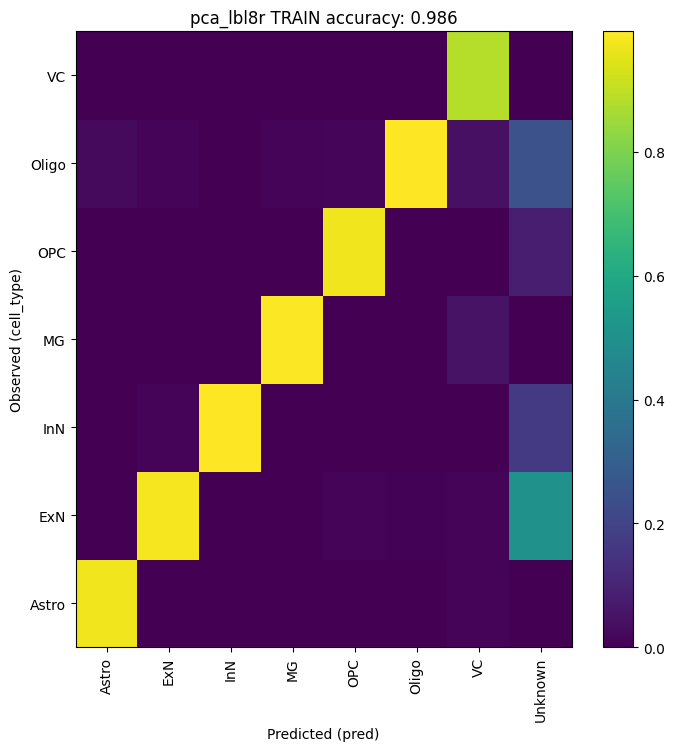

In [28]:

plot_predictions(train_ad, pred_key="pred", cell_type_key="cell_type", model_name="raw_lbl8r", title_str="TRAIN")


In [17]:
if retrain:
    lbl8r_path = model_path / "LBL8Rpca"
    raw_lbl8r.save(lbl8r_path, overwrite=True)

------------------
Now TEST

In [13]:
filen = data_path / XYLENA_TEST
test_ad = ad.read_h5ad(filen)

# subsamples = np.random.choice(test_ad.shape[0], 10_000, replace=False)
# test_ad = test_ad[subsamples,:] # no copy... just alias

In [15]:

LBL8R.setup_anndata(test_ad, labels_key=labels_key)

test_predictions = raw_lbl8r.predict(test_ad, probs=False, soft=True)




INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
(502085, 50)


In [26]:
test_ad = add_predictions_to_adata(test_ad, test_predictions, insert_key="pred", pred_key="label")


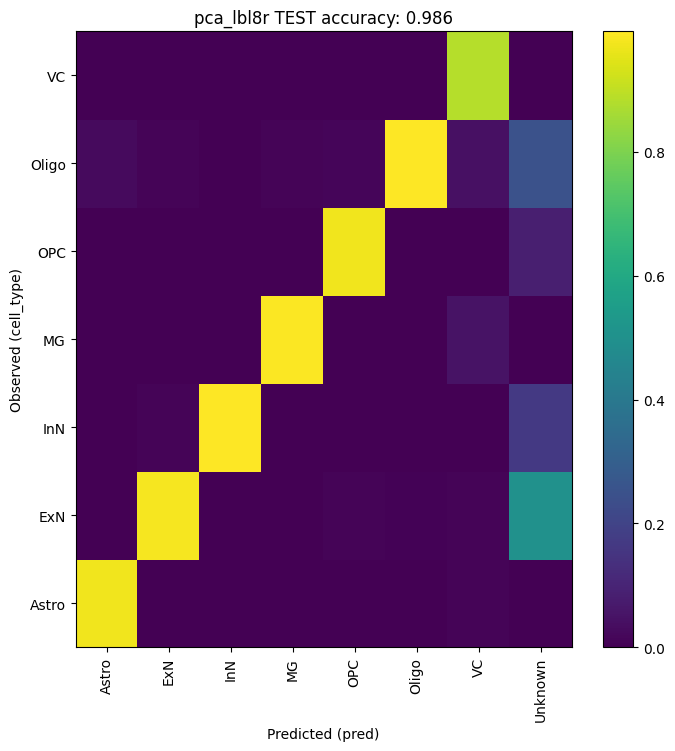

In [27]:
plot_predictions(test_ad, pred_key="pred", cell_type_key="cell_type", model_name="raw_lbl8r", title_str="TEST")


--------------

## pcaLBL8R on normalized PCAs 

To give the pca "baseline" a fair shake its important to use normalized counts.  Using the `scVI` normalization is our best shot... (Although the current models are NOT batch correcting since we don't have a good strategy to do this with probe data)

In [23]:
filen = data_path / XYLENA_ANNDATA.replace(".h5ad", "_train_scvi_normalized.h5ad")
norm_train_ad = ad.read_h5ad(filen)


In [34]:
labels_key = 'cell_type'
n_labels = len(norm_train_ad.obs[labels_key].cat.categories)
LBL8R.setup_anndata(norm_train_ad, labels_key=labels_key)

norm_lbl8_path = model_path / "LBL8R_scVInorm"
if norm_lbl8_path.exists() and not retrain:
    norm_lbl8r = LBL8R.load(norm_lbl8_path,norm_train_ad.copy())
else:
    norm_lbl8r = LBL8R(norm_train_ad, n_labels=n_labels)
    norm_lbl8r.train()


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/ergonyc/miniforge3/envs/scverse11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve perform

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 124/400:  31%|███       | 124/400 [10:55<24:19,  5.29s/it, v_num=1, train_loss_step=0.0131, train_loss_epoch=0.0611] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.056. Signaling Trainer to stop.


In [ ]:
predictions = norm_lbl8r.predict( probs=False, soft=True)

norm_train_ad = add_predictions_to_adata(norm_train_ad, predictions, insert_key="pred", pred_key="label")


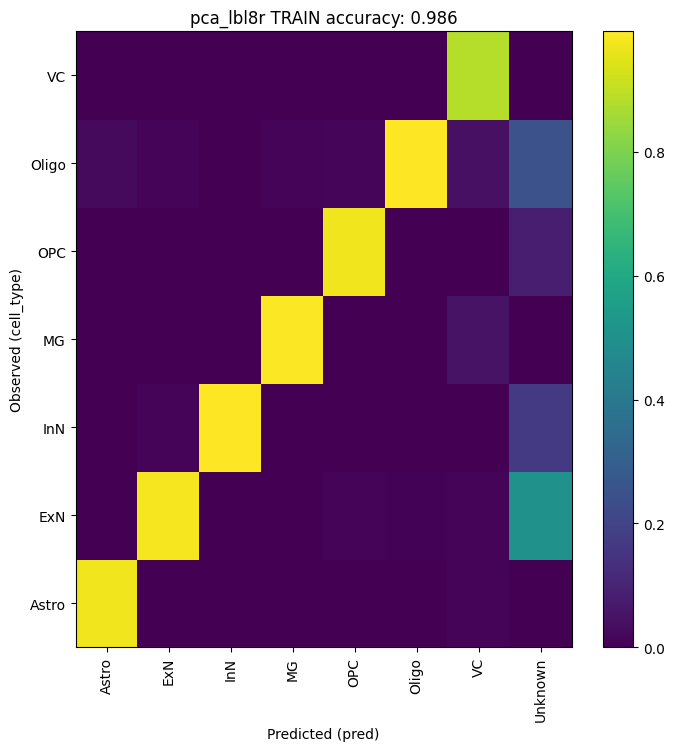

In [ ]:

plot_predictions(norm_train_ad, pred_key="pred", cell_type_key="cell_type", model_name="norm_lbl8r", title_str="TRAIN")


In [ ]:
if retrain:
    norm_lbl8_path = model_path / "LBL8R_scVInorm"
    norm_lbl8r.save(norm_lbl8_path, overwrite=True)

test scvi normalized loadings

In [ ]:
filen = data_path / XYLENA_ANNDATA.replace(".h5ad", "_test_scvi_normalized.h5ad")
norm_test_ad = ad.read_h5ad(filen)


In [27]:

LBL8R.setup_anndata(norm_test_ad, labels_key=labels_key)

test_predictions = norm_lbl8r.predict(norm_test_ad, probs=False, soft=True)

norm_test_ad = add_predictions_to_adata(norm_test_ad, test_predictions, insert_key="pred", pred_key="label")


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Users/ergonyc/Projects/SingleCell/scvi-tools/scvi/data/fields/_dataframe_field.py:189: UserWarning: Category 7 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/Users/ergonyc/Projects/SingleCell/scvi-tools/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 7 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


(207726, 3000)


In [ ]:
plot_predictions(norm_test_ad, pred_key="pred", cell_type_key="cell_type", model_name="norm_lbl8r", title_str="TEST")
